In [1]:
!unzip Booking_Jobs_All_220218.csv.zip

Archive:  Booking_Jobs_All_220218.csv.zip
  inflating: Booking_Jobs_All_220218.csv  


In [2]:

!pip install contractions
!pip install rake-nltk
!pip install umap-learn
!pip install wordcloud
!pip install yake


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import contractions
import seaborn as sns
import spacy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
from collections import defaultdict
import umap
import yake
import nltk
import numpy as np

In [4]:
# yake_extractor = yake.KeywordExtractor()

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [7]:
df=pd.read_csv("Booking_Jobs_All_220218.csv")
nlp = spacy.load('en_core_web_sm')

In [8]:
df["length"]=df["Job Description"].str.len()

<ipython-input-9-fcc9d2dd8673>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["length"])


<Axes: xlabel='length', ylabel='Density'>

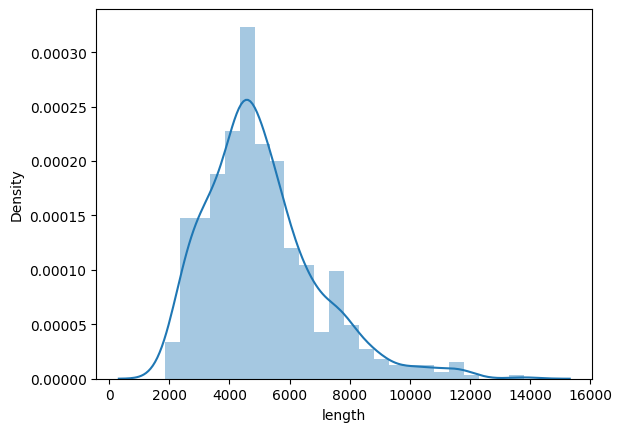

In [9]:
sns.distplot(df["length"])

In [10]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### PreProcssing
1. we need to use contraction, so that sentence become more meaningful
2. Removing numbers, hyperlinks and extra spaces, as these acts as a clutter in our documents
3. we have removed the stop words and lemmatizes the word to make the word more in there natural form

In [11]:
def clean_text(text):
    # Remove numbers, .com, and hyperlinks
    text= contractions.fix(text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\b\w+\.com\b', '', text)  # Remove .com URLs
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove hyperlinks
    # Remove special characters and extra spaces
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # words = nltk.word_tokenize(text)
    # pos_tags = pos_tag(words)
    # processed_words = [
    #     lemmatizer.lemmatize(word, get_wordnet_pos(tag)).lower()
    #     for word, tag in pos_tags
    #     if word.lower() not in stop_words  # Remove stopwords
    # ]
    doc=nlp(text)

    filtered_words = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(filtered_words)

In [12]:
df_train=pd.DataFrame()
df_train["Job Description"]=df["Job Description"].apply(lambda x: clean_text(x))

In [13]:
df_train.head(3)

,Job Description
0,long ago book trip Eiffel Tower stroll New Y...
1,datum drive decision Technology core innovatio...
2,s global treasury team look Treasury risk ma...


### Using sentence transformer to generathe embeddings of the documents

In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
embeddings=model.encode(list(df_train["Job Description"]))

In [17]:
# gmm = GaussianMixture(n_components=653, random_state=42)

In [18]:
# gmm.fit(embeddings)

In [19]:
# labels = gmm.predict(embeddings)

In [20]:
# sil_score = silhouette_score(embeddings, labels)

In [21]:
# print(sil_score)

### To reduce the dimension of the embeddings we are using umap to reduct the dimension of our embeddings to 64

In [22]:
umap_model = umap.UMAP(n_components=64, random_state=42)

In [23]:
X_umap =umap_model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [24]:
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
# plt.colorbar(scatter, label='Cluster')
# plt.title('UMAP Visualization of KMeans Clusters')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.show()

In [25]:
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(X_umap[:, 10], X_umap[:, 11], c=kmeans.labels_, cmap='viridis', s=50)
# plt.colorbar(scatter, label='Cluster')
# plt.title('UMAP Visualization of KMeans Clusters')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.show()

### Using elbow method and kmeans we can see around 12-14 cluster is ideal, we are going to use 12 clusters

100%|██████████| 48/48 [00:07<00:00,  6.02it/s]


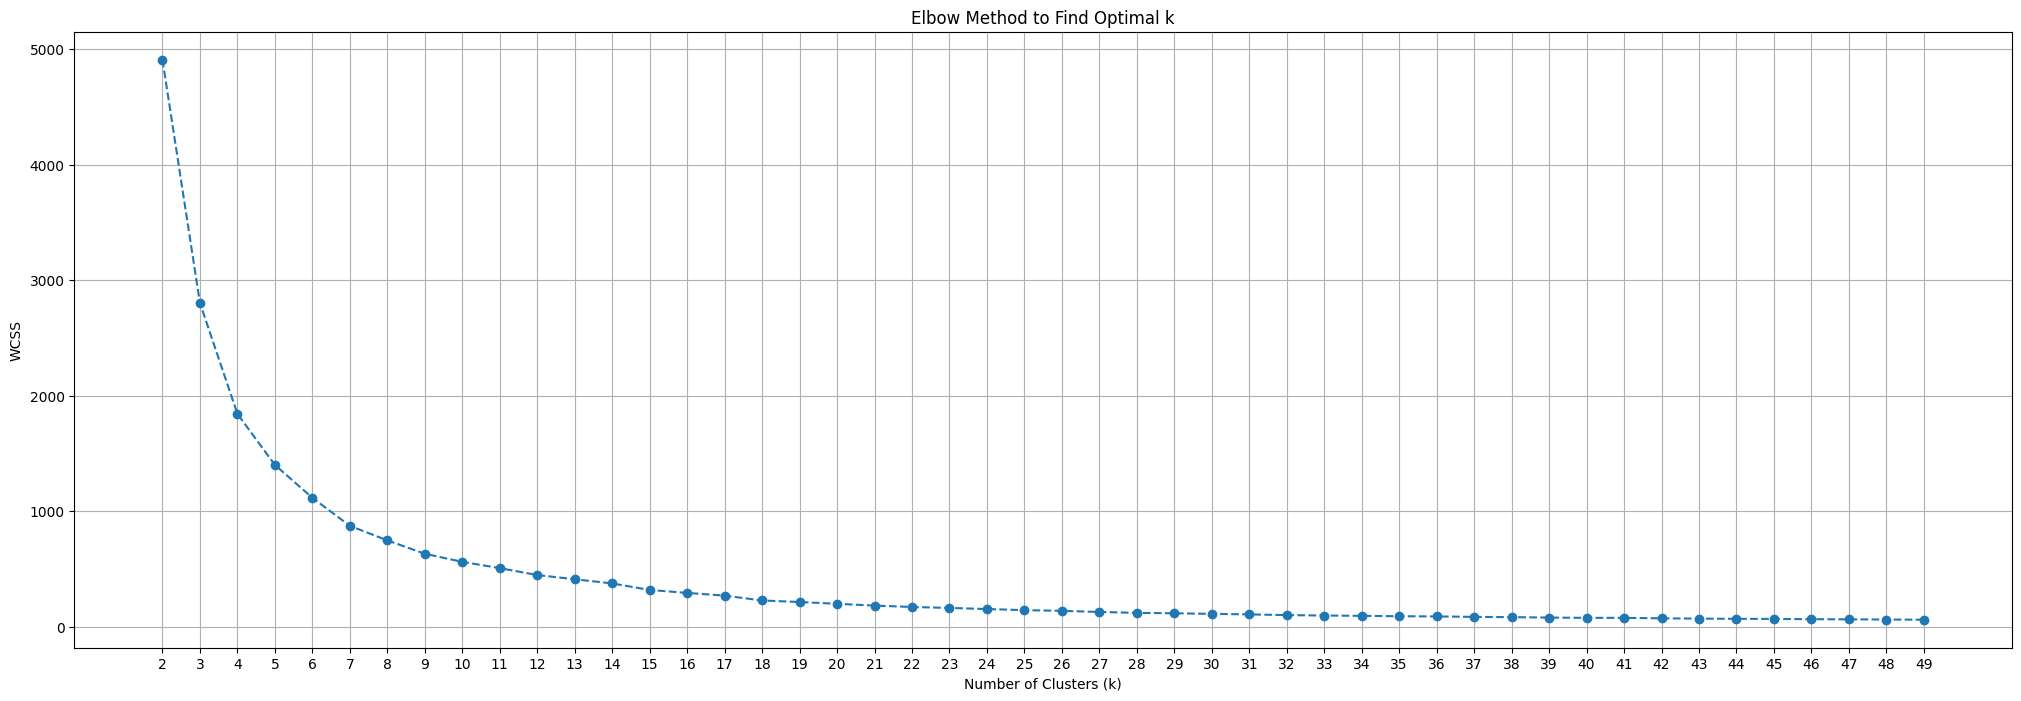

In [26]:
wcss=[]
sil_scores=[]
k_values = range(2, 50)
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=42)
    kmeans.fit(X_umap)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS


# Plot the elbow curve
plt.figure(figsize=(25, 8))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Find Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [27]:
kmeans2 = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=10, random_state=42)
kmeans2.fit(X_umap)

KMeans(max_iter=100, n_clusters=12, n_init=10, random_state=42)

In [43]:
job_labels=list(kmeans2.labels_)

### Using tf-idf to generate n-gram features. It will work as follow
for each document, we are generating ngram features and computing the similarity with the document, and taking top n maximum feature

In [29]:
tfidf=TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, min_df=4
                      )

In [30]:
feature_matrix=tfidf.fit_transform(df_train["Job Description"]).toarray()

In [31]:
ngram_feature_train=tfidf.get_feature_names_out()

In [32]:
X_umap.shape

(653, 64)

In [33]:
all_keywords=[]
for idx,i in tqdm(enumerate(list(df_train["Job Description"]))):
  # print(idx)
  temp_keywords={}
  row = feature_matrix[idx]
  # print(row.nonzero())
  indices = row.nonzero()
  all_feature_word=[]
  for ind in indices:
    all_feature_word.append(ngram_feature_train[ind].tolist())
  # print(type(all_feature_word))


  for ngramword in list(all_feature_word[0]):
    # print(ngramword)
    embed=model.encode([ngramword])
    exmbed_x=umap_model.transform(embed.reshape(1,-1))
    # print(X_umap[idx].reshape(1,-1).shape)
    # print(exmbed_x.reshape(1,-1).shape)
    # print(f"sim idx {idx}")
    sim=cosine_similarity(X_umap[idx].reshape(1,-1),exmbed_x)
    # print(sim)
    # print(j)
    temp_keywords[ngramword]=sim[0][0]

  all_keywords.append(temp_keywords)




653it [1:01:46,  5.68s/it]


In [45]:
len(all_keywords)

653

{'absorb': 0.9986101,
 'accord': 0.99097914,
 'accurate': 0.9991502,
 'accurately': 0.99920726,
 'achieve': 0.99986255,
 'achieve goal': 0.9996611,
 'act': 0.99498415,
 'act intermediary': 0.9951466,
 'actively': 0.99790937,
 'actively monitor': 0.9955632,
 'ad': 0.9968409,
 'add': 0.9968787,
 'add perk': 0.9903916,
 'address': 0.9978113,
 'administration': 0.9943485,
 'ago': 0.9999379,
 'ago book': 0.999928,
 'ahead': 0.99986833,
 'ahead strategic': 0.99411035,
 'aim': 0.99317837,
 'alert': 0.999154,
 'ambitious': 0.99986756,
 'analysis': 0.9920138,
 'analyze': 0.99242175,
 'apple': 0.9922798,
 'application': 0.99161655,
 'asset': 0.99670875,
 'asset management': 0.99317646,
 'assist': 0.99677116,
 'automate': 0.9917136,
 'avenue': 0.99904233,
 'avenue feel': 0.99911714,
 'aw': 0.9975569,
 'away': 0.999883,
 'away right': 0.9995963,
 'azure': 0.98801327,
 'bash': 0.9892391,
 'beach': 0.99988544,
 'beach simply': 0.99977154,
 'beauty': 0.9990134,
 'beauty discover': 0.99954814,
 'belie

### creating result df

In [48]:
topk=10
labels=[]
cluster_imp_key={}
keywords=[]
for data,lbl in zip(all_keywords,job_labels):
  labels.append(lbl)
  temptkeywords=sorted(data.items(), key=lambda x: x[1], reverse=True)[:topk]
  cluster_imp_key[lbl]=temptkeywords
  joinkeys=[]
  for ti in temptkeywords:
    joinkeys.append(ti[0])
  keywords.append(", ".join(joinkeys))




In [41]:

# keywords=[]
# for i in cluster_imp_key:
#   labels.append(i)
#   allkeys=cluster_imp_key[i]
#   tempkeywords=[]
#   for k in allkeys:
#     tempkeywords.append(k[0])

#   keywords.append(", ".join(tempkeywords))

In [50]:
df_train["labels"]=labels
df_train["keywords"]=keywords

In [51]:
df_train.to_excel("results.xlsx")

In [36]:
# def plot_wordcloud(cluster_num, word_scores):
#   wordcloud=WordCloud(background_color='white').generate_from_frequencies(word_scores)
#   plt.figure(figsize=(8,2))
#   plt.imshow(wordcloud, interpolation='bilinear')

In [37]:
# for clustidx in cluster_imp_key:
#   plot_wordcloud(clustidx, cluster_imp_key[clustidx])

In [38]:
# test_tfid=tfidf.transform(["looking for job in ml"])
# for i, sentence in enumerate(["looking for job in ml"]):
#     print(f"\nSentence {i + 1}: '{sentence}'")
#     print("N-grams and their TF-IDF values:")

#     # Get non-zero n-grams and their values
#     row = test_tfid[i]
#     indices = row.nonzero()[1]  # Non-zero feature indices
#     for idx in indices:
#         print(f"  {ngram_feature_train[idx]}: {row[0, idx]:.4f}")


In [39]:
import joblib
joblib.dump(kmeans,"kmeans.pkl")
joblib.dump(tfidf,"tfidf.pkl")
joblib.dump(umap_model,"umap.pkl")

['umap.pkl']